```
출처: https://github.com/awjuliani/DeepRL-Agents/blob/master/gridworld.py
출처: http://localhost:8888/notebooks/Desktop/%EA%B0%95%EC%9D%98%EA%B4%80%EB%A0%A8/Chap6.Double-Dueling-DQN.ipynb
@주석 및 정리 : MyungHoon-Jin
정리글 링크: 
```

# **dddqn & gridworld explain**
- 에이전트는 파란색 사각형(hero)를 위, 아래, 왼쪽, 오른쪽으로 이동시킨다.
- 목표는 빨간색 사각형(hole, -1의 보상)을 피하여 녹색 사각형(goal, +1의 보상)까지 도달하는 것
- 세가지 블록의 위치는 매 에피소드마다 랜덤하게 변한다.

## 1. gridworld.py
- 게임의 세가지 object와 Environment(state)를 정의한다.

In [1]:
# import library
import numpy as np # vector 연산을 위해 호출
import random # 각 위치를 randomize하게 뽑기 위해 호출
import itertools # iterable한 객체 control을 위해 호출
import scipy.misc # input image의 size를 84*84로 대체할 때 사용
                  # scipy 최신 버전에서는 사라질 모듈, Pillow로 대체
import matplotlib.pyplot as plt # image를 시각화하기 위해 호출

In [2]:
class gameOb():
    """
    # 각 Game Object를 정의하기 위한 객체
    """
    def __init__(self, coordinates, size, intensity, channel, reward, name):
        self.x = coordinates[0]    # x 좌표
        self.y = coordinates[1]    # y 좌표
        self.size = size           # object 크기
        self.intensity = intensity # 0~1, 색을 얼마나 진하게 표시할 지 결정
                                   # 이 예제에서는 전부 1
        self.channel = channel     # hero, goal, fire의 3 채널.
                                   # 이미지에서 RBG 채널로 사용
        self.reward = reward       # 강화학습에서 사용할 보상 설정
        self.name = name           # hero, goal, fire

In [232]:
from PIL import Image
class gameEnv():
    """
    # GridWorld를 구축하기 위한 class
    """
    def __init__(self, partial, size):
        """
        ---------------------------------------------------
        # 객체의 초기값 설정
          partial : bool, 학습할 이미지의 전체를 볼지(False) 
                  부분을 볼지(True) 결정
          size : int, 학습할 이미지의 각 축 길이를 지정
        ---------------------------------------------------
        # 호출하는 다른 메서드
          self.reset() : game object를 생성하고
                         위치를 랜덤하게 지정
        ---------------------------------------------------
        """
        self.sizeX = size
        self.sizeY = size
        self.actions = 4 # 상하좌우 4가지 action을 가짐
        self.objects = [] # 각 객체를 저장할 list 생성
        self.partial = partial # 전체를 볼지 부분을 볼지 저장
        a = self.reset() # hero * 1, bug * 4, hole * 2을 지정된 좌표평면 하에서
                         # 위치를 랜덤하게 지정하여 생성
        plt.imshow(a,interpolation="nearest") # 초기 state를 image로 보여줌
        
        
    def reset(self):
        """
        ---------------------------------------------------
        # hero, bug, hole의 각기 객체를 생성,
          위치를 랜덤하게 지정하고
          reward, intensity, name 등을 지정
        ---------------------------------------------------
        # 각 객체의 초기값 정보 요약
               | size intensity channel reward   name
          .....|......................................
          hero |    1         1      2    None   hero
          bug  |    1         1      1      +1   goal
          hole |    1         1      0      -1   fire
        ---------------------------------------------------
        # 호출하는 다른 메서드
          self.newPosition() : 현재 좌표평면에 object가 있는지
                               여부를 파악,
                               있다면 그 자리를 피하여
                               객체의 좌표를 지정
          self.renderEnv() : 각 객체의 정보를 기반으로
                             self.partial==True라면 일부만,
                             self.partial==False이면 전체의
                             좌표를 읽고 84*84*3 image로 변환
                             (widths, heights, RGB Channel)
        ---------------------------------------------------
        """
        self.objects = [] # reset 할 때마다 object 목록을 초기화
        hero = gameOb(self.newPosition(),1,1,2,None,'hero') # hero object 생성
        self.objects.append(hero)
        bug = gameOb(self.newPosition(),1,1,1,1,'goal') # bug object 생성
        self.objects.append(bug)
        hole = gameOb(self.newPosition(),1,1,0,-1,'fire') # hole object 생성
        self.objects.append(hole)
        bug2 = gameOb(self.newPosition(),1,1,1,1,'goal') # bug object 생성
        self.objects.append(bug2)
        hole2 = gameOb(self.newPosition(),1,1,0,-1,'fire') # hole object 생성
        self.objects.append(hole2)
        bug3 = gameOb(self.newPosition(),1,1,1,1,'goal') # bug object 생성
        self.objects.append(bug3)
        bug4 = gameOb(self.newPosition(),1,1,1,1,'goal') # bug object 생성
        self.objects.append(bug4)
        state = self.renderEnv() # 현재 상태정보를 반환
        self.state = state
        return state
    
    def newPosition(self):
        """
        ---------------------------------------------------
        # GridWorld의 새 object의 좌표를 결정
          기존의 object의 위치와 겹치지 않게 새로운 좌표를
          랜덤하게 부여
        ---------------------------------------------------
        """
        # 좌표 생성 ----------------------------------------------------
        # GridWorld의 모든 좌표를 iterable한 객체로 저장
        # 아래 코드는 아래의 한줄 코드로 대체 가능
        # [(i, j) for i in range(self,sizeX) for j in range(self.sizeY)]
        iterables = [range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        # object 현재 위치 탐색 ----------------------------------------
        currentPositions = []
        for objectA in self.objects:
            if (objectA.x, objectA.y) not in currentPositions:
                currentPositions.append((objectA.x, objectA.y))
        # 좌표평면 상에서 기존 object가 위치하고 있는 좌표 제거 --------
        for pos in currentPositions:
            points.remove(pos)
        # random하게 임의의 위치를 선정한 후에 좌표를 반환 -------------
        location = np.random.choice(range(len(points)),replace=False)
        return points[location]

    def renderEnv(self):
        """
        ---------------------------------------------------
        # hero : Blue, goal : Green, fire : Red로 색을
          부여하기 위해 아래와 같은 작업을 수행
          ................................................
          Enviroment에서 현재 상태를 image로 출력
          (input_size+2 * input_sise+2 * 3)의 image 생성
            - 각 객체별 intensity로 3D 위치 지정
              (Channel 별로 기존 좌표 분리)
            - self.partial==True이면 hero 객체를 기준으로
              (3 * 3 * 3) image를 생성
          ................................................
          위에서 처리한 이미지를 (84*84*3)으로 resize 한 후
          결과값을 반환
        ---------------------------------------------------
        # return 값은 강화학습에서 상태 정보를 이미지로
          학습하기 위한 값
        ---------------------------------------------------
        """
        #a = np.zeros([self.sizeY,self.sizeX,3])
        a = np.ones([self.sizeY + 2, 
                     self.sizeX + 2, 
                     3])
        a[1:-1,1:-1,:] = 0
        hero = None
        for item in self.objects:
            a[item.y + 1 : item.y + item.size + 1,
              item.x + 1 : item.x + item.size + 1,
              item.channel] = item.intensity
            if item.name == 'hero':
                hero = item
        if self.partial == True:
            a = a[hero.y:hero.y+3,hero.x:hero.x+3,:]
        # DeprecationWarning: scipy 1.3.0에서 사라질 함수
#         b = scipy.misc.imresize(a[:,:,0],[84,84,1],interp='nearest')
#         c = scipy.misc.imresize(a[:,:,1],[84,84,1],interp='nearest')
#         d = scipy.misc.imresize(a[:,:,2],[84,84,1],interp='nearest')
        R = np.array(Image.fromarray(a[:,:,0], mode=None).resize((84, 84)),
                     dtype=np.int32) * 255
        G = np.array(Image.fromarray(a[:,:,1], mode=None).resize((84, 84)),
                     dtype=np.int32) * 255
        B = np.array(Image.fromarray(a[:,:,2], mode=None).resize((84, 84)),
                     dtype=np.int32) * 255
        a = np.stack([R,G,B],axis=2)
        return a

    def step(self,action):
        """
        ---------------------------------------------------
        # 상태 s에서 행동 a를 취했을 경우의 보상과
          다음 상태 s`을 반환
          action : int, 해당 step에서 취할 action
        ---------------------------------------------------
        # 호출하는 다른 메서드
          self.moveChar(action)
          self.checkGoal()
          self.renderEnv()
        ---------------------------------------------------
        # return은 state, reward+penalty, done으로 구성
          state : 행동을 취한 후의 새로운 상태집합(이미지)
          reward + penalty : 행동을 취한 후의 보상
                             본 예제에서 페널티는 0
          done : 종료 조건이 있을 경우 True
                 본 예제에서는 항상 False
        ---------------------------------------------------
        """
        penalty = self.moveChar(action) # 이 예제에서는 항상 0
        reward,done = self.checkGoal()
        state = self.renderEnv()
        return state,(reward+penalty), done

    def moveChar(self, direction):
        """
        ---------------------------------------------------
        # 주어진 action대로 hero를 움직인다.
          direction : action의 방향
          (0 - up, 1 - down, 2 - left, 3 - right)
        ---------------------------------------------------
        """
        # hero의 현재 좌표를 반환한다 --------------------
        # (0, 0) -> (1, 0)으로 움직이면 좌표평면 상에서는
        # x축 오른쪽으로 한 칸 이동한 모습을 상상할 수 있다
        # 그러나 행렬 상에서는 row를 한 칸 내리는 연산 이므로
        # 결과적으로 아래로 한 칸 이동하게 된다.
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        # 행동에 대한 초기 패널티를 설정한다 -------------
        # 이 예제에서는 행동에 대한 패널티는 없다.
        penalize = 0.
        # 주어진 action대로 hero를 이동시킨다 ------------
        # 행동반경 밖에 나갔을 경우에는 이동시키지 않는다.
        if (direction == 0) and (hero.y >= 1):
            hero.y -= 1
        if (direction == 1) and (hero.y <= self.sizeY - 2):
            hero.y += 1
        if (direction == 2) and (hero.x >= 1):
            hero.x -= 1
        if (direction == 3) and (hero.x <= self.sizeX - 2):
            hero.x += 1     
        if (hero.x == heroX) and (hero.y == heroY):
            penalize = 0.0
        # 움직인 hero의 좌표를 기록하고 penalty를 반환한다
        self.objects[0] = hero
        return penalize
    
    def checkGoal(self):
        """
        ---------------------------------------------------
        # hero를 움직이고 난 후에 보상을 판정한다.
            - goal에 도달했을 경우에는 +1을,
            - hole에 도달했을 경우에는 -1을,
            - 그 외에는 보상 0을 획득한다.
          goal이나 hole에 도달했을 경우, 이를 제거하고
          새롭게 임의의 위치에 goal/hole을 배치한다.
        ---------------------------------------------------
        # return은 reward와 done으로 구성된다.
          reward : goal일 경우 1, hole일 경우 -1, 그 외 0
          done : bool, 종료 조건이 존재할 경우 True를 반환
                 현재의 예시에서는 특정 횟수(50) 안에서
                 최대한 많은 보상을 얻게 학습시키는 예제,
                 done은 항상 False를 반환한다.
        ---------------------------------------------------
        """
        # hero와 나머지 객체를 구분하여 저장 -------------
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        # hero의 좌표와 goal, hole의 좌표를 비교, 보상을 부여한다
        # 만일 goal, hole에 접근했을 경우, 기존의 객체를 제거하고
        # 새로운 객체를 배치한다.
        for other in others:
            if (hero.x, hero.y) == (other.x, other.y):
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(),1,1,1,1,'goal'))
                elif other.reward == -1:
                    self.objects.append(gameOb(self.newPosition(),1,1,0,-1,'fire'))
                return other.reward, False
        return 0.0, False

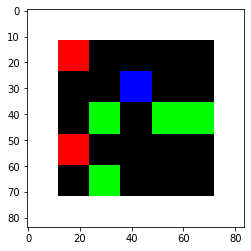

In [233]:
partial = False
size = 5
env = gameEnv(partial=partial, size=size)

In [234]:
for ob in env.objects:
    print(ob.name, (ob.x, ob.y))

hero (2, 1)
goal (3, 2)
fire (0, 3)
goal (4, 2)
fire (0, 0)
goal (1, 2)
goal (1, 4)


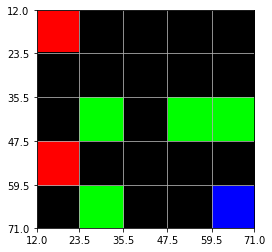

In [261]:
env.moveChar(3)
plt.imshow(env.renderEnv(), interpolation="nearest")
plt.axis([12, 71, 71, 12])
plt.xticks([12, 23.5, 35.5, 47.5, 59.5, 71])
plt.yticks([71, 59.5, 47.5, 35.5, 23.5, 12])
plt.grid(True); plt.show()

In [231]:
for ob in env.objects:
    print(ob.name, (ob.x, ob.y))

hero (3, 3)
goal (0, 3)
fire (0, 4)
goal (1, 4)
fire (3, 1)
goal (4, 0)
goal (4, 2)


## 2. Double Dueling DQN: GridWorld

In [262]:
# import gym # 강화학습의 환경을 제공, 여기서는 GridWorld class를 저으이했기 때문에 사용하지 않음
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim # 저수준의 tensorflow API를 간편하게 사용할 수 있는 고수준 경량 API
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

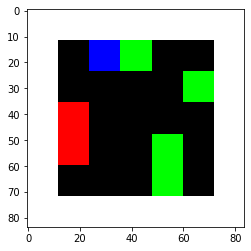

In [263]:
#========= 게임 환경 로딩 =========#

env = gameEnv(partial=False,size=5)

#### plot tensorboard

In [278]:
import tensorflow as tf
tf.reset_default_graph()

In [279]:
# 아래의 Network를 메모리에 직접 업로드
# Q) class를 메모리에 올려도 tensorflow graph가 그려질 것인가?
# A) Maybe yes... 확인해볼 것
# 시도해보니 안되는 것을 확인. 이렇게 직접 graph를 구축해야 그릴 수 있다.

# 저수준의 tensorflow API를 간편하게 사용할 수 있는 고수준 경량 API
# https://www.popit.kr/tf-slim-%EC%8B%9C%EC%9E%91%ED%95%98%EA%B8%B0/
import tensorflow.contrib.slim as slim
#네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다 (flattening).
#배열의 크기를 재조절해주고 4개의 컨벌루션 레이어를 거치면서 처리해 준다.
scalarInput =  tf.placeholder(shape=[None,84*84*3],dtype=tf.float32)
imageIn = tf.reshape(scalarInput,shape=[-1,84,84,3])
conv1 = slim.conv2d(inputs=imageIn, num_outputs=32, kernel_size=[8,8],
                    stride=[4,4],padding='VALID', 
                    biases_initializer=None)
conv2 = slim.conv2d(inputs=conv1, num_outputs=64, kernel_size=[4,4],
                    stride=[2,2],padding='VALID', 
                    biases_initializer=None)
conv3 = slim.conv2d(inputs=conv2, num_outputs=64, kernel_size=[3,3],
                    stride=[1,1],padding='VALID', 
                    biases_initializer=None)
conv4 = slim.conv2d(inputs=conv3, num_outputs=h_size, kernel_size=[7,7],
                    stride=[1,1],padding='VALID', 
                    biases_initializer=None)

# 마지막 컨벌루션 레이어로부터의 출력값을 취한 후, 
# 이를 어드밴티지 스트림과 값 스트림으로 분리한다. 
streamAC, streamVC = tf.split(conv4, 2, 3) # value, num_or_size_splits, axis
                                           # 1*1*512 -> [1*1*256, 1*1*256]
streamA = slim.flatten(streamAC) # 256
streamV = slim.flatten(streamVC) # 256
AW = tf.Variable(tf.random_normal([h_size//2, env.actions])) # 256*6
VW = tf.Variable(tf.random_normal([h_size//2,1])) # 256*1
Advantage = tf.matmul(streamA, AW)
Value = tf.matmul(streamV, VW)

#최종 Q-값을 얻기 위해 어드밴티지 스트림과 값 스트림을 조합해 준다. 
Qout = Value + tf.subtract(Advantage,
                           tf.reduce_mean(Advantage, axis=1,
                                          keep_dims=True)
                          )
predict = tf.argmax(Qout, 1)

#타겟 Q 값과 예측 Q 값 간의 제곱합 차를 취함으로써 비용을 구한다.
targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
actions = tf.placeholder(shape=[None],dtype=tf.int32)
actions_onehot = tf.one_hot(actions, env.actions, # indices : A Tensor of indices
                            dtype=tf.float32) # depth : A scalar defining the depth of the one hot dimention

Q = tf.reduce_sum(tf.multiply(Qout, actions_onehot), axis=1)

td_error = tf.square(targetQ - Q)
loss = tf.reduce_mean(td_error)
trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
updateModel = trainer.minimize(loss)

In [280]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter('./tensordata/logs', sess.graph)

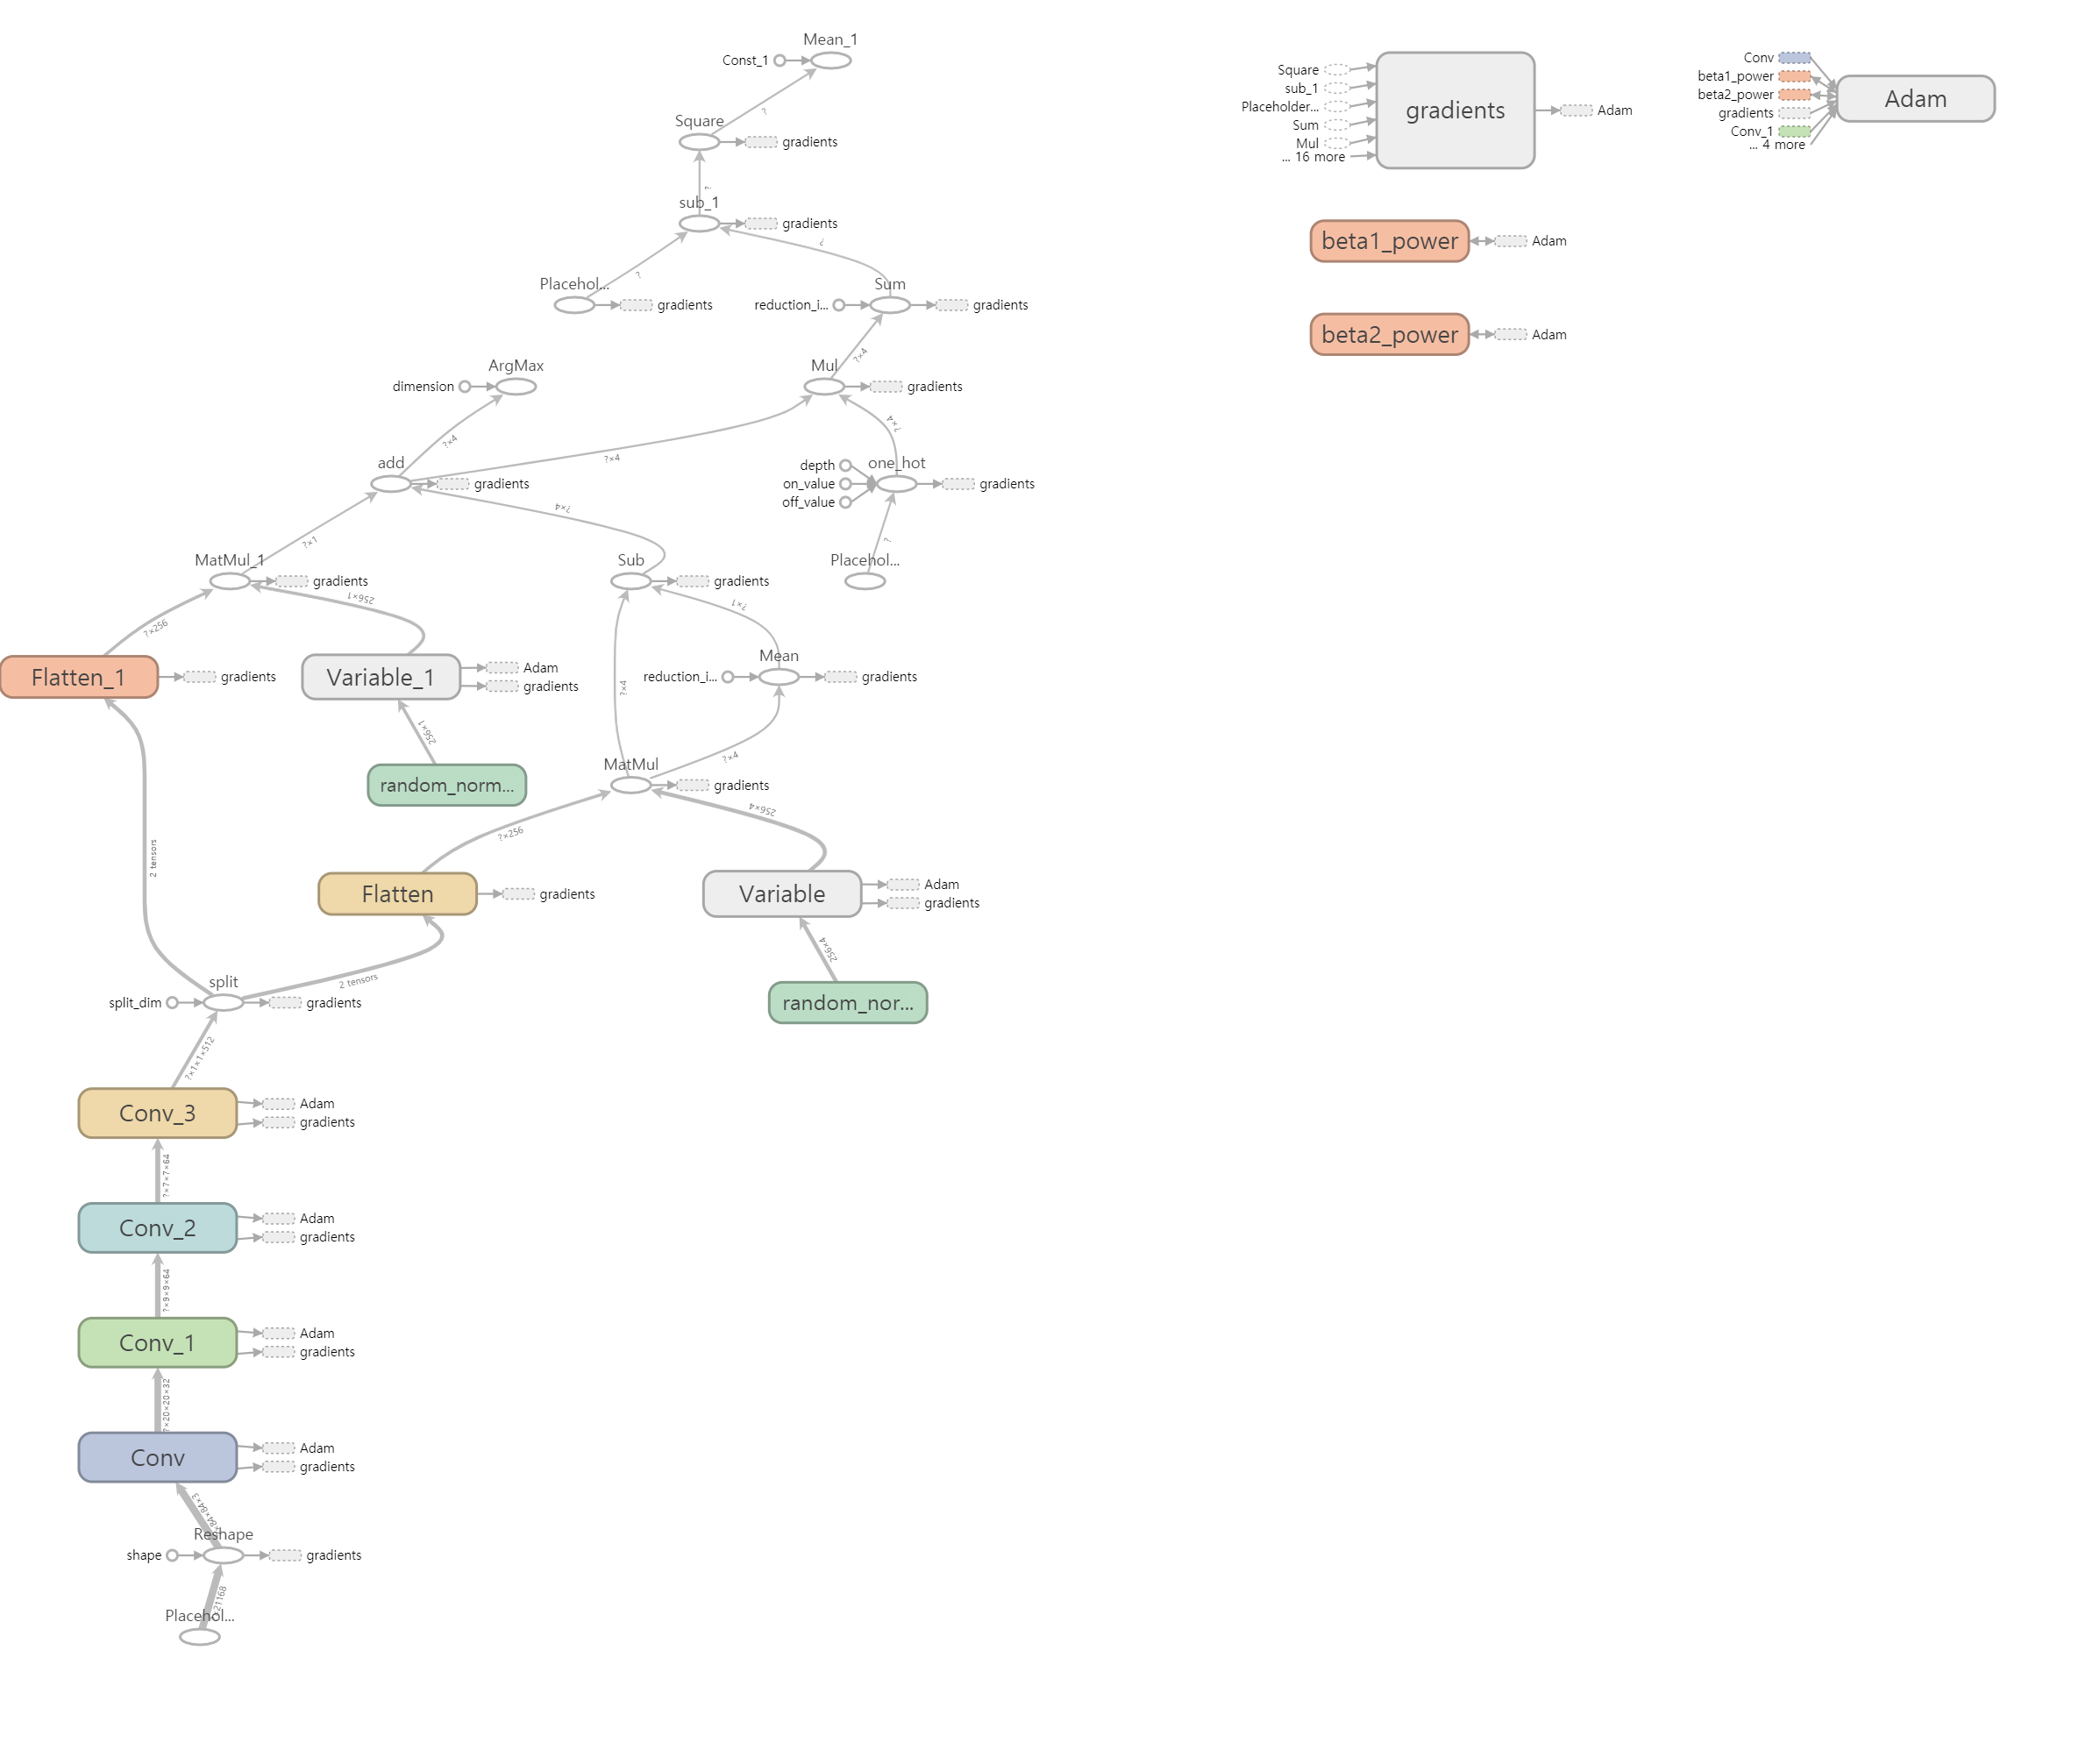

In [273]:
Image.open('graph_run=.png')

#### Dueling DQN
- $\alpha,\;\beta$ are parameters of the two streams of fully-connected layers
$$Q(s,a;\theta,\alpha,\beta)=V(s;\theta,\beta)+\bigg(A(s,a;\theta,\alpha)-\frac{1}{|\mathcal{A}|}\sum_{a'}{A(s,a';\theta,\alpha)}\bigg)$$

In [315]:
np.ones((10, 1)) + (np.random.randint(2, size=(10,4)) - np.arange(10).reshape(-1, 1))

array([[ 2.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.],
       [-1.,  0., -1., -1.],
       [-1., -1., -1., -1.],
       [-3., -3., -2., -3.],
       [-3., -3., -4., -3.],
       [-5., -5., -5., -4.],
       [-5., -6., -5., -5.],
       [-7., -7., -6., -7.],
       [-7., -7., -7., -8.]])

In [290]:
tf.reset_default_graph()
data =  np.array(
    [[.5, .4, .2, .6]])
X = tf.constant(data)
data = np.array(
    [[0., 0., 0., 1.],
     [0., 0., 1., 0.],
     [1., 0., 0., 0.],
     [0., 1., 0., 0.],
     [0., 0., 1., 0.],
     [0., 1., 0., 0.],
     [0., 1., 0., 0.],
     [0., 0., 0., 1.],
     [1., 0., 0., 0.],
     [0., 1., 0., 0.],
     [0., 0., 0., 1.],
     [0., 0., 1., 0.]])
Y = tf.constant(data)
matres = tf.multiply(X, Y)
with tf.Session() as sess:
    print(sess.run(matres))

[[0.  0.  0.  0.6]
 [0.  0.  0.2 0. ]
 [0.5 0.  0.  0. ]
 [0.  0.4 0.  0. ]
 [0.  0.  0.2 0. ]
 [0.  0.4 0.  0. ]
 [0.  0.4 0.  0. ]
 [0.  0.  0.  0.6]
 [0.5 0.  0.  0. ]
 [0.  0.4 0.  0. ]
 [0.  0.  0.  0.6]
 [0.  0.  0.2 0. ]]


In [316]:
#========= 네트워크 구현 =========#

class Qnetwork():
    def __init__(self,h_size):
        """
        ---------------------------------------------------
        # 네트워크는 다음과 같이 구성된다.
          | - Input Image를 읽어들인다
          +              Input shape : (None, 84 * 84 * 3)
          +             output shape : (None, 84 * 84 * 3)
          | - CNN으로 상태 집합을 구성하기 위해 Image reshape
             +          output shape : (None, 84, 84, 3)
        (#1) --- Conv1
             +    kernel = (8, 8), stride = (4, 4)
             +    num_filters = 32
             +    > Calc : 8 * '1' + 4 * '19' = 84, Hence '20'
             +          output shape : (None, 20, 20, 32)
        (#2) --- Conv2
             +    kernel = (4, 4), stride = (2, 2)
             +    num_filters = 64
             +    > Calc : 4 * '1' + 2 * '8' = 20, Hence '9'
             +          output shape : (None, 9, 9, 64)
        (#3) --- Conv3
             +    kernel = (3, 3), stride = (1, 1)
             +    num_filters = 64
             +    > Calc : 3 * '1' + 1 * '6' = 9, Hence '7'
             +          output shape : (None, 7, 7, 64)
        (#4) --- Conv4
             +    kernel = (7, 7), stride = (1, 1)
             +    num_filters = h_size
             +    > Calc : 7 * '1' + 1 * '0' = 7, Hence '1'
             +          output shape : (None, 1, 1, h_size)
          | - Dueling Idea 적용을 위해 CNN으로 읽은 상태 집합을
          |   2분할하여 Value(s)와 Advantage(a) 으로 구성
          +              Input shape : (None, 1, 1, h_size)
             --- tf.split(value, num_split=2, axis=3)
             + (streamAC)
             +          output shape : (None, 1, 1, h_size / 2)
             + (streamVC)
             +          output shape : (None, 1, 1, h_size / 2)
             --- tf.flatten() # 이미지 처리 단계 종료, vector로 변환
             + (streamAC)
             +          output shape : (None, h_size / 2)
             + (streamVC)
             +          output shape : (None, h_size / 2)
             --- set tf.Variable() # Weight 설정
        (#5) + (AW)
             +                 shape : (h_size / 2, 4)
             >                   # action의 수는 4개(상하좌우)
        (#6) + (VW)
             +                 shape : (h_size / 2, 1)
             --- tf.matmul # Matrix Multiplication
             + (Advantage) = (streamAC) * (WA)
             +             (None, h_size / 2) * (h_size / 2, 4)
             +          output shape : (None, 4)
             + (Value) = (streamVC) * (WV)
             +             (None, h_size / 2) * (h_size / 2, 1)
             +          output shape : (None, 1)
          | 위의 결과로 Dueling DQN의 A-C function을 계산
             + (Qout) = Value + (Advantage - mean(Advantage))
             +          output shape : (None, 4) # Broadcasting
             + (predict) = argmax(Qout)
             +          output shape : (None, 4) # Broadcasting
        ---------------------------------------------------
        """
        # 네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다 (flattening).
        # 배열의 크기를 재조절해주고 4개의 컨벌루션 레이어를 거치면서 처리해 준다.
        self.scalarInput =  tf.placeholder(shape=[None, 84 * 84 * 3],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1, 84, 84, 3])
        self.conv1 = slim.conv2d(inputs=self.imageIn, num_outputs=32, kernel_size=[8,8],
                                 stride=[4,4], padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d(inputs=self.conv1, num_outputs=64, kernel_size=[4,4],
                                 stride=[2,2], padding='VALID', biases_initializer=None)
        
        self.conv3 = slim.conv2d(inputs=self.conv2, num_outputs=64, kernel_size=[3,3],
                                 stride=[1,1], padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d(inputs=self.conv3, num_outputs=h_size, kernel_size=[7,7],
                                 stride=[1,1],padding='VALID', biases_initializer=None)
        
        #마지막 컨벌루션 레이어로부터의 출력값을 취한 후, 이를 어드밴티지 스트림과 값 스트림으로 분리한다. 
        self.streamAC, self.streamVC = tf.split(self.conv4, num_or_size_splits=2, axis=3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2, env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        #최종 Q-값을 얻기 위해 어드밴티지 스트림과 값 스트림을 조합해 준다. 
        self.Qout = self.Value + tf.subtract(self.Advantage,
                                             tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        #타겟 Q 값과 예측 Q 값 간의 제곱합 차를 취함으로써 비용을 구한다.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, depth=env.actions, dtype=tf.float32)
        
        self.Q = tf.reduce_sum(
                    tf.multiply(self.Qout, 
                                self.actions_onehot)
            , axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [317]:
#========= 경험 재생 =========#
# 다음 클래스는 경험과 샘플을 저장하고 랜덤하게 신경망을 학습시킨다 
        
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(
            np.array(
                random.sample(self.buffer,
                              size)
            ),
            [size, 5])

In [318]:
#다음은 게임의 프레임의 사이즈를 조절해 주는 간단한 함수이다.
def processState(states):
    return np.reshape(states,[84*84*3])

In [319]:
#아래 함수들은 1차 신경망의 파라미터와 함께 목표 신경망의 파라미터를 업데이트하게 해준다
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [320]:
#========= 신경망 학습 =========#

#모든 학습 파라미터를 설정한다            
batch_size = 32          # 각 학습 단계에서 사용할 경험의 수
update_freq = 4          # 학습 단계 기준의 업데이트 주기 
y = .99                  # 타겟 Q-값에 대한 할인 계수
startE = 1               # 시작 시 랜덤 액션의 가능성
endE = 0.1               # 종료 시 랜덤 액션의 가능성
anneling_steps = 10000.  # startE에서 endE로 줄어드는데 필요한 학습 단계 수
num_episodes = 10000     # 네트워크를 학습시키기 위한 게임 환경 에피소드의 수
pre_train_steps = 10000  # 학습 시작 전 랜덤 액션의 단계 수
max_epLength = 50        # 허용되는 최대 에피소드 길이
load_model = False       # 저장된 모델을 로딩할 지 여부
path = "./dqn"           # 모델을 저장할 경로
h_size = 512             # 어드밴티지 스트림과 값 스트림으로 분리되기 전의 마지막 컨벌루션 레이어의 크기
tau = 0.001              # 타겟 네트워크를 제1네트워크로 업데이트시켜 가는 비율

In [321]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

In [325]:
#랜덤 액션이 감소하는 비율을 설정 
e = startE # 1
stepDrop = (startE - endE)/anneling_steps # (1 - 0.1) / 10000.

#전체 보상과 에피소드 별 단계 수를 저장할 리스트를 생성
jList = []
rList = []
total_steps = 0

# #모델이 저장될 경로 생성
# if not os.path.exists(path):
#     os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps, sess) #타겟 네트워크가 제1네트워크와 동일하도록 설정
    for i in range(num_episodes): # num_episodes
        episodeBuffer = experience_buffer()
        #환경을 리셋하고 첫번째 관찰 얻기
        s = env.reset()
        s = processState(s) # 84*84*3=21168
        d = False
        rAll = 0
        j = 0
        #Q-네트워크
        while j < max_epLength: #만약 에이전트가 블록에 도달하기 위해 200회 이상 시도하면 종료
            j+=1
            # Q-네트워크로부터 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택한다.
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                action = np.random.randint(0,4)
            else:
                action = sess.run(mainQN.predict,
                             feed_dict={mainQN.scalarInput:[s]})[0]
            # gameEnv.step()
            # penalty = gameEnv.moveChar(action=a)
                # 주어진 행동으로 hero를 움직이는 함수
                # always 0.
            # reward, done = self.checkGoal()
                # hero vs others
                # hero와 others의 좌표를 비교,
                    # 같을 경우 그 객체를 제거하고
                    # goal에 갔을 경우 새로운 goal을 생성,
                    # fire에 갔을 경우 새로운 fire을 생성
                    # 그 reward와 False를 반환
                # 같지 않을 경우, return 0.0, False (always)
            # state = self.renderEnv()
                # 현재 좌표상태를 계산 및 반환
                # 84*84*3으로~
            s1,r,d = env.step(action) # state, reward, False
            s1 = processState(s1) # 84*84*3으로 만들어줌
            total_steps += 1
            # 에피소드 버퍼에 경험을 저장
            # state, action, reward, state2, False
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) 
            
            if total_steps > pre_train_steps: # pre_train_steps
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0: # update_freq = 4
                                                     # C step?
                    trainBatch = myBuffer.sample(batch_size) # 경험에서 특정 부분을 랜덤하게 획득
                                                             # batch_size = 32
                                                             # (32, 5)
                    #타겟 Q-값에 대해 double DQN 업데이트를 수행
                    Q1 = sess.run(mainQN.predict,
                                  feed_dict={
                                      mainQN.scalarInput:np.vstack(trainBatch[:,3]) # new state
                                  })
                    Q2 = sess.run(targetQN.Qout,
                                  feed_dict={
                                      targetQN.scalarInput:np.vstack(trainBatch[:,3]) # new state
                                  })
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #타겟 값을 이용해 네트워크를 업데이트
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={
                            mainQN.scalarInput : np.vstack(trainBatch[:,0]),
                            mainQN.targetQ : targetQ, 
                            mainQN.actions : trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #타겟 네트워크가 제1네트워크와 동일하도록 설정
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #정기적으로 모델 저장
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model
500 1.1 1
1000 1.0 1
1500 2.3 1
2000 2.3 1
2500 0.5 1
3000 1.0 1
3500 1.7 1
4000 2.7 1
4500 2.3 1
5000 1.4 1
5500 0.9 1
6000 2.6 1
6500 1.6 1
7000 0.9 1
7500 1.2 1
8000 3.9 1
8500 2.4 1
9000 1.3 1
9500 2.8 1
10000 1.3 1


KeyboardInterrupt: 

In [341]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

with tf.Session() as sess:
    sess.run(init)
    Q1 = sess.run(mainQN.predict,
                  feed_dict={
                      mainQN.scalarInput:np.vstack(trainBatch[:,3]) # new state
                  })
    Q2 = sess.run(targetQN.Qout,
                  feed_dict={
                      targetQN.scalarInput:np.vstack(trainBatch[:,3]) # new state
                  })

In [349]:
end_multiplier = -(trainBatch[:, 4] - 1)
end_multiplier

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=object)

In [350]:
Q2[range(batch_size), Q1]

array([181.0923  ,  92.417435, -50.946404, 113.4232  , 182.42154 ,
       168.18118 ,  75.61208 , 207.73514 , 211.04578 ,  99.25722 ,
       118.333046, 117.44194 , 141.22417 , 112.171646, 175.491   ,
        70.57971 ,  85.73305 , 167.7597  , 191.96445 , 167.65453 ,
       130.06079 ,  72.92262 , 107.37286 , 238.92068 , 127.58009 ,
       127.13217 ,  79.98879 , 129.91492 , 121.43916 , 156.7764  ,
       182.15875 , 180.0875  ], dtype=float32)

In [353]:
y

0.99

In [354]:
trainBatch[:, 2] + .99 * Q2[range(batch_size), Q1] * end_multiplier

array([179.2813720703125, 91.4932632446289, -50.43693923950195,
       112.28897094726562, 179.59732055664062, 167.49937438964844,
       74.85596466064453, 205.6577911376953, 208.93531799316406,
       98.2646484375, 118.14971923828125, 116.26752471923828,
       139.81192016601562, 111.04993438720703, 173.736083984375,
       70.87391662597656, 84.87571716308594, 166.0821075439453,
       190.0447998046875, 165.9779815673828, 128.7601776123047,
       72.19339752197266, 106.29913330078125, 236.53147888183594,
       126.30429077148438, 125.86084747314453, 79.18890380859375,
       128.6157684326172, 120.22476959228516, 155.20863342285156,
       180.33717346191406, 178.28662109375], dtype=object)